In [53]:
from windpowerlib import ModelChain, WindTurbine, create_power_curve
from windpowerlib import data as wt

In [54]:
# Get logging messages from the windpowerlib
import logging
#logging.getLogger().setLevel(logging.DEBUG)

In [55]:
import os
import requests
import pandas as pd

# Get weather data (from wind)
def get_weather_data(filename='weather.csv', **kwargs):
    r"""
    Imports weather data from a file.

    The data include wind speed at two different heights in m/s, air
    temperature in two different heights in K, surface roughness length in m
    and air pressure in Pa. The height in m for which the data applies is
    specified in the second row.
    In case no weather data file exists, an example weather data file is 
    automatically downloaded and stored in the same directory as this example.

    Parameters
    ----------
    filename : str
        Filename of the weather data file. Default: 'weather.csv'.

    Other Parameters
    ----------------
    datapath : str, optional
        Path where the weather data file is stored.
        Default is the same directory this example is stored in.

    Returns
    -------
    :pandas:`pandas.DataFrame<frame>`
        DataFrame with time series for wind speed `wind_speed` in m/s,
        temperature `temperature` in K, roughness length `roughness_length`
        in m, and pressure `pressure` in Pa.
        The columns of the DataFrame are a MultiIndex where the first level
        contains the variable name as string (e.g. 'wind_speed') and the
        second level contains the height as integer at which it applies
        (e.g. 10, if it was measured at a height of 10 m). The index is a 
        DateTimeIndex.

    """

    if 'datapath' not in kwargs:
        kwargs['datapath'] = os.path.dirname(__file__)
    
    file = os.path.join(kwargs['datapath'], filename)
    
    # download example weather data file in case it does not yet exist
    if not os.path.isfile(file):
        logging.debug("Download weather data for example.")
        req = requests.get("https://osf.io/59bqn/download")
        with open(file, "wb") as fout:
            fout.write(req.content)
            
    # read csv file 
    weather_df = pd.read_csv(
        file,
        index_col=0,
        header=[0, 1],
        date_parser=lambda idx: pd.to_datetime(idx, utc=True))
    
    # change time zone
    weather_df.index = weather_df.index.tz_convert(
        'Europe/Berlin')
    
    return weather_df


# Read weather data from csv
weather = get_weather_data(filename='weather.csv', datapath='')
print(weather[['wind_speed', 'temperature', 'pressure']][:25])

print(weather[['wind_speed', 'temperature', 'pressure']][:25].index)

variable_name             wind_speed          temperature         pressure
height                            10       80           2      10        0
2010-01-01 00:00:00+01:00    5.32697  7.80697      267.60  267.57  98405.7
2010-01-01 01:00:00+01:00    5.46199  7.86199      267.60  267.55  98382.7
2010-01-01 02:00:00+01:00    5.67899  8.59899      267.61  267.54  98362.9
2010-01-01 03:00:00+01:00    5.68466  7.89466      267.63  267.56  98340.9
2010-01-01 04:00:00+01:00    5.38084  7.57084      267.63  267.61  98336.8
2010-01-01 05:00:00+01:00    5.28286  7.51286      267.61  267.55  98334.2
2010-01-01 06:00:00+01:00    5.43709  7.73709      267.55  267.52  98324.6
2010-01-01 07:00:00+01:00    5.49162  8.22162      267.51  267.46  98345.1
2010-01-01 08:00:00+01:00    5.52631  7.76631      267.48  267.45  98394.9
2010-01-01 09:00:00+01:00    5.57199  7.74199      267.67  267.60  98446.6
2010-01-01 10:00:00+01:00    5.38384  7.94384      267.95  267.88  98486.0
2010-01-01 11:00:00+01:00

In [56]:
# Get a table of all wind turbines for which power and/or power coefficient curves are provided

# List of all available wind turbines
df = wt.get_turbine_types(print_out=True)

print("")

# Find all Enercon wind turbines
print(df[df["manufacturer"].str.contains("Enercon")])

       manufacturer  turbine_type  has_power_curve  has_cp_curve
0       Adwen/Areva    AD116/5000             True         False
1           Enercon    E-101/3050             True          True
2           Enercon    E-101/3500             True          True
3           Enercon    E-115/3000             True          True
4           Enercon    E-115/3200             True          True
5           Enercon    E-126/4200             True          True
6           Enercon    E-126/7500             True         False
7           Enercon    E-126/7580             True         False
8           Enercon    E-141/4200             True          True
9           Enercon      E-53/800             True          True
10          Enercon     E-70/2000             True         False
11          Enercon     E-70/2300             True          True
12          Enercon     E-82/2000             True          True
13          Enercon     E-82/2300             True          True
14          Enercon     E

In [57]:
# Find all Enercon 126 turbines
print(df[df["turbine_type"].str.contains("E-126")])

  manufacturer turbine_type  has_power_curve  has_cp_curve
5      Enercon   E-126/4200             True          True
6      Enercon   E-126/7500             True         False
7      Enercon   E-126/7580             True         False


In [58]:
# Specification of wind turbine

enercon_e126 = {
        'turbine_type': 'E-126/4200',  # turbine type as in oedb turbine library
        'hub_height': 135  # in m
    }

# Initialize WindTurbine object
e126 = WindTurbine(**enercon_e126)

In [59]:
# Power output calculation for e126

# Own specifications for ModelChain setup
modelchain_data = {
    'wind_speed_model': 'logarithmic',      # 'logarithmic' (default),
                                            # 'hellman' or
                                            # 'interpolation_extrapolation'
    'density_model': 'ideal_gas',           # 'barometric' (default), 'ideal_gas'
                                            #  or 'interpolation_extrapolation'
    'temperature_model': 'linear_gradient', # 'linear_gradient' (def.) or
                                            # 'interpolation_extrapolation'
    'power_output_model':
        'power_coefficient_curve',          # 'power_curve' (default) or
                                            # 'power_coefficient_curve'
    'density_correction': True,             # False (default) or True
    'obstacle_height': 0,                   # default: 0
    'hellman_exp': None}                    # None (default) or None


In [60]:
# Initialize ModelChain with own specifications and use run_model method to calculate power output
mc_e126 = ModelChain(e126, **modelchain_data).run_model(weather)

# Write power output time series to WindTurbine object
e126.power_output = mc_e126.power_output

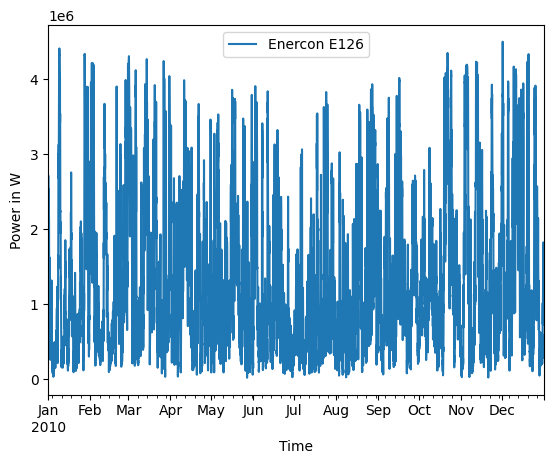

In [61]:
# Plot wind production
from matplotlib import pyplot as plt

e126.power_output.plot(legend=True, label='Enercon E126')
plt.xlabel('Time')
plt.ylabel('Power in W')
plt.show()

<AxesSubplot:>

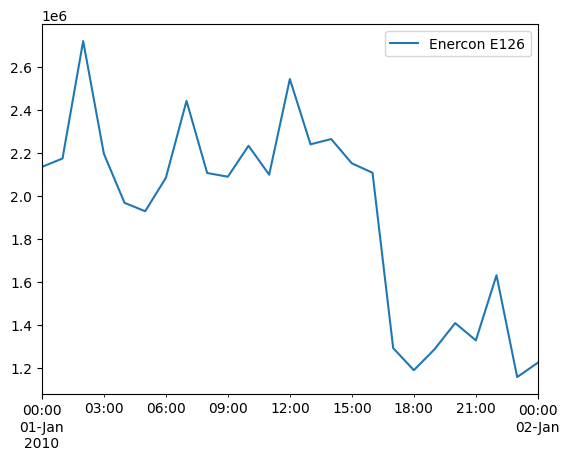

In [62]:
# Plot first day of Wind production
wind_power = e126.power_output
wind_power = wind_power[:25]
wind_power.plot(legend=True, label='Enercon E126')

In [63]:
# Get only first day
wind_power = wind_power[:25]

In [64]:
#Normalize wind production
max_value = wind_power.max()
factor = 100

wind_power_norm = wind_power/max_value * factor
print(max_value)
print(wind_power_norm)

2718768.9958937005
2010-01-01 00:00:00+01:00     78.476256
2010-01-01 01:00:00+01:00     79.917431
2010-01-01 02:00:00+01:00    100.000000
2010-01-01 03:00:00+01:00     80.749623
2010-01-01 04:00:00+01:00     72.336815
2010-01-01 05:00:00+01:00     70.900729
2010-01-01 06:00:00+01:00     76.600178
2010-01-01 07:00:00+01:00     89.769324
2010-01-01 08:00:00+01:00     77.437054
2010-01-01 09:00:00+01:00     76.801215
2010-01-01 10:00:00+01:00     82.093154
2010-01-01 11:00:00+01:00     77.148495
2010-01-01 12:00:00+01:00     93.507001
2010-01-01 13:00:00+01:00     82.344426
2010-01-01 14:00:00+01:00     83.238009
2010-01-01 15:00:00+01:00     79.088732
2010-01-01 16:00:00+01:00     77.479494
2010-01-01 17:00:00+01:00     47.494692
2010-01-01 18:00:00+01:00     43.707573
2010-01-01 19:00:00+01:00     47.287006
2010-01-01 20:00:00+01:00     51.771229
2010-01-01 21:00:00+01:00     48.810880
2010-01-01 22:00:00+01:00     59.955563
2010-01-01 23:00:00+01:00     42.534397
2010-01-02 00:00:00+0

<AxesSubplot:>

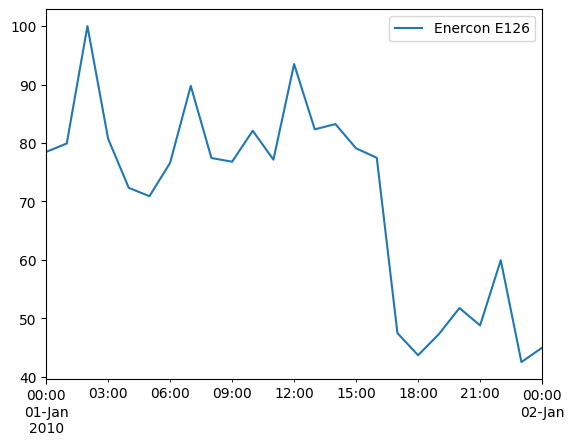

In [65]:
# Plot wind production of first day after the normalization
wind_power_norm.plot(legend=True, label='Enercon E126')

In [66]:
# Using Tomorrow.io API to get wind data
url = "https://api.tomorrow.io/v4/timelines?location=-73.98529171943665,40.75872069597532&fields=pressureSurfaceLevel,pressureSeaLevel,precipitationIntensity,precipitationType,windSpeed,windGust,windDirection,temperature,temperatureApparent,cloudCover,cloudBase,cloudCeiling,weatherCode&timesteps=1h&units=metric&apikey=Yckmp3vREbJqyprWGGiTOC1pVaAYO0ZT"
wind_data = requests.get(url)
print(wind_data.json()["data"]["timelines"][0]["intervals"][1:])

[{'startTime': '2022-10-10T21:00:00Z', 'values': {'cloudBase': None, 'cloudCeiling': None, 'cloudCover': 42.19, 'precipitationIntensity': 0, 'precipitationType': 0, 'pressureSeaLevel': 1003.24, 'pressureSurfaceLevel': 635.55, 'temperature': -46.38, 'temperatureApparent': -66.22, 'weatherCode': 1100, 'windDirection': 126.66, 'windGust': 9.81, 'windSpeed': 7.62}}, {'startTime': '2022-10-10T22:00:00Z', 'values': {'cloudBase': None, 'cloudCeiling': None, 'cloudCover': 26.56, 'precipitationIntensity': 0, 'precipitationType': 0, 'pressureSeaLevel': 1003.53, 'pressureSurfaceLevel': 635.85, 'temperature': -46.85, 'temperatureApparent': -66.7, 'weatherCode': 1100, 'windDirection': 128.61, 'windGust': 9.66, 'windSpeed': 7.51}}, {'startTime': '2022-10-10T23:00:00Z', 'values': {'cloudBase': None, 'cloudCeiling': None, 'cloudCover': 24.22, 'precipitationIntensity': 0, 'precipitationType': 0, 'pressureSeaLevel': 1003.42, 'pressureSurfaceLevel': 636.04, 'temperature': -47.22, 'temperatureApparent': -

In [67]:
intervals = wind_data.json()["data"]["timelines"][0]["intervals"][1:]

In [68]:
print(intervals)

[{'startTime': '2022-10-10T21:00:00Z', 'values': {'cloudBase': None, 'cloudCeiling': None, 'cloudCover': 42.19, 'precipitationIntensity': 0, 'precipitationType': 0, 'pressureSeaLevel': 1003.24, 'pressureSurfaceLevel': 635.55, 'temperature': -46.38, 'temperatureApparent': -66.22, 'weatherCode': 1100, 'windDirection': 126.66, 'windGust': 9.81, 'windSpeed': 7.62}}, {'startTime': '2022-10-10T22:00:00Z', 'values': {'cloudBase': None, 'cloudCeiling': None, 'cloudCover': 26.56, 'precipitationIntensity': 0, 'precipitationType': 0, 'pressureSeaLevel': 1003.53, 'pressureSurfaceLevel': 635.85, 'temperature': -46.85, 'temperatureApparent': -66.7, 'weatherCode': 1100, 'windDirection': 128.61, 'windGust': 9.66, 'windSpeed': 7.51}}, {'startTime': '2022-10-10T23:00:00Z', 'values': {'cloudBase': None, 'cloudCeiling': None, 'cloudCover': 24.22, 'precipitationIntensity': 0, 'precipitationType': 0, 'pressureSeaLevel': 1003.42, 'pressureSurfaceLevel': 636.04, 'temperature': -47.22, 'temperatureApparent': -

In [69]:
for i in intervals:
    i["wind_speed"] = i["values"]["windSpeed"]
    i["temperature"] = i["values"]["temperature"]
    i["pressure"] = i["values"]["pressureSurfaceLevel"]
    del i['values']
print(intervals[:25])

[{'startTime': '2022-10-10T21:00:00Z', 'wind_speed': 7.62, 'temperature': -46.38, 'pressure': 635.55}, {'startTime': '2022-10-10T22:00:00Z', 'wind_speed': 7.51, 'temperature': -46.85, 'pressure': 635.85}, {'startTime': '2022-10-10T23:00:00Z', 'wind_speed': 7.25, 'temperature': -47.22, 'pressure': 636.04}, {'startTime': '2022-10-11T00:00:00Z', 'wind_speed': 6.93, 'temperature': -47.53, 'pressure': 636.33}, {'startTime': '2022-10-11T01:00:00Z', 'wind_speed': 6.7, 'temperature': -47.76, 'pressure': 636.5}, {'startTime': '2022-10-11T02:00:00Z', 'wind_speed': 6.68, 'temperature': -47.98, 'pressure': 636.48}, {'startTime': '2022-10-11T03:00:00Z', 'wind_speed': 6.62, 'temperature': -47.8, 'pressure': 636.67}, {'startTime': '2022-10-11T04:00:00Z', 'wind_speed': 6.19, 'temperature': -47.31, 'pressure': 636.62}, {'startTime': '2022-10-11T05:00:00Z', 'wind_speed': 5.92, 'temperature': -46.69, 'pressure': 636.66}, {'startTime': '2022-10-11T06:00:00Z', 'wind_speed': 5.79, 'temperature': -45.88, 'pr

In [70]:
wind_data_df = pd.DataFrame.from_dict(intervals[:25])
wind_data_df['startTime'] = pd.to_datetime(wind_data_df['startTime'])
wind_data_df = wind_data_df.set_index('startTime')

print(wind_data_df)

                           wind_speed  temperature  pressure
startTime                                                   
2022-10-10 21:00:00+00:00        7.62       -46.38    635.55
2022-10-10 22:00:00+00:00        7.51       -46.85    635.85
2022-10-10 23:00:00+00:00        7.25       -47.22    636.04
2022-10-11 00:00:00+00:00        6.93       -47.53    636.33
2022-10-11 01:00:00+00:00        6.70       -47.76    636.50
2022-10-11 02:00:00+00:00        6.68       -47.98    636.48
2022-10-11 03:00:00+00:00        6.62       -47.80    636.67
2022-10-11 04:00:00+00:00        6.19       -47.31    636.62
2022-10-11 05:00:00+00:00        5.92       -46.69    636.66
2022-10-11 06:00:00+00:00        5.79       -45.88    636.42
2022-10-11 07:00:00+00:00        5.54       -45.13    636.30
2022-10-11 08:00:00+00:00        5.32       -44.54    636.30
2022-10-11 09:00:00+00:00        5.53       -44.20    636.05
2022-10-11 10:00:00+00:00        5.80       -44.36    636.00
2022-10-11 11:00:00+00:0

In [71]:
print(weather[['wind_speed', 'temperature', 'pressure']][:25])

variable_name             wind_speed          temperature         pressure
height                            10       80          2       10       0 
2010-01-01 00:00:00+01:00    5.32697  7.80697      267.60  267.57  98405.7
2010-01-01 01:00:00+01:00    5.46199  7.86199      267.60  267.55  98382.7
2010-01-01 02:00:00+01:00    5.67899  8.59899      267.61  267.54  98362.9
2010-01-01 03:00:00+01:00    5.68466  7.89466      267.63  267.56  98340.9
2010-01-01 04:00:00+01:00    5.38084  7.57084      267.63  267.61  98336.8
2010-01-01 05:00:00+01:00    5.28286  7.51286      267.61  267.55  98334.2
2010-01-01 06:00:00+01:00    5.43709  7.73709      267.55  267.52  98324.6
2010-01-01 07:00:00+01:00    5.49162  8.22162      267.51  267.46  98345.1
2010-01-01 08:00:00+01:00    5.52631  7.76631      267.48  267.45  98394.9
2010-01-01 09:00:00+01:00    5.57199  7.74199      267.67  267.60  98446.6
2010-01-01 10:00:00+01:00    5.38384  7.94384      267.95  267.88  98486.0
2010-01-01 11:00:00+01:00

In [72]:
#print(weather[['wind_speed', 'temperature', 'pressure']][:24]["wind_speed"][10])
n_row = 0
weather = weather.reset_index()
wind_data_df = wind_data_df.reset_index()

for index, i in weather[['index', 'wind_speed', 'temperature', 'pressure']][:25].iterrows():
    weather.loc[index, "wind_speed"] = wind_data_df.iloc[n_row]["wind_speed"]
    weather.loc[index, "temperature"] = wind_data_df.iloc[n_row]["temperature"]
    weather.loc[index, "pressure"] = wind_data_df.iloc[n_row]["pressure"]
    weather.loc[index, "index"] = wind_data_df.iloc[n_row]["startTime"]
    #print(weather.loc[index, "startTime"])
    n_row+=1
    
weather.set_index('index', inplace=True)
wind_data_df = weather
    
print(wind_data_df[["index", "wind_speed", "temperature", "pressure"]][:25])

variable_name             wind_speed       temperature        pressure
height                            10    80           2     10        0
index                                                                 
2022-10-10 21:00:00+00:00       7.62  7.62      -46.38 -46.38   635.55
2022-10-10 22:00:00+00:00       7.51  7.51      -46.85 -46.85   635.85
2022-10-10 23:00:00+00:00       7.25  7.25      -47.22 -47.22   636.04
2022-10-11 00:00:00+00:00       6.93  6.93      -47.53 -47.53   636.33
2022-10-11 01:00:00+00:00       6.70  6.70      -47.76 -47.76   636.50
2022-10-11 02:00:00+00:00       6.68  6.68      -47.98 -47.98   636.48
2022-10-11 03:00:00+00:00       6.62  6.62      -47.80 -47.80   636.67
2022-10-11 04:00:00+00:00       6.19  6.19      -47.31 -47.31   636.62
2022-10-11 05:00:00+00:00       5.92  5.92      -46.69 -46.69   636.66
2022-10-11 06:00:00+00:00       5.79  5.79      -45.88 -45.88   636.42
2022-10-11 07:00:00+00:00       5.54  5.54      -45.13 -45.13   636.30
2022-1

In [73]:
mc_e126_b = ModelChain(e126, **modelchain_data).run_model(wind_data_df)

# Write power output time series to WindTurbine object
e126.power_output = mc_e126_b.power_output

<AxesSubplot:xlabel='index'>

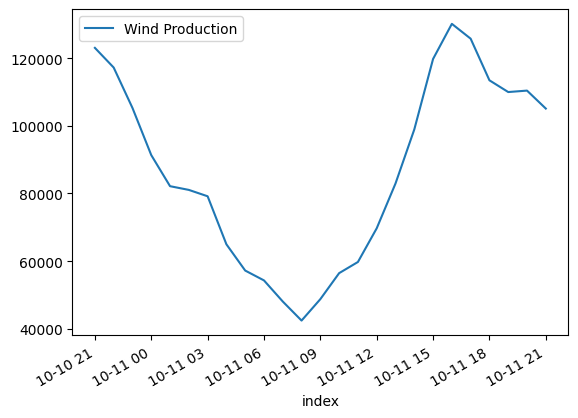

In [28]:
# Plot first day of Wind production
wind_power = e126.power_output
wind_power = wind_power[:25]
wind_power.plot(legend=True, label='Wind Production')

<AxesSubplot:>

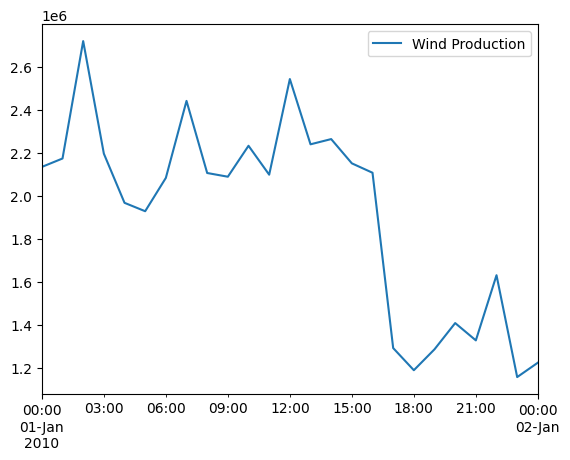

In [76]:
wind_power.plot(legend=True, label='Wind Production')

2010-01-01 00:00:00+01:00    2.133588e+06
2010-01-01 00:01:00+01:00    2.116710e+06
2010-01-01 00:02:00+01:00    2.100647e+06
2010-01-01 00:03:00+01:00    2.085387e+06
2010-01-01 00:04:00+01:00    2.070920e+06
                                 ...     
2010-01-01 23:55:00+01:00    1.145284e+06
2010-01-01 23:56:00+01:00    1.159473e+06
2010-01-01 23:57:00+01:00    1.174361e+06
2010-01-01 23:58:00+01:00    1.189961e+06
2010-01-01 23:59:00+01:00    1.206281e+06
Freq: T, Name: feedin_power_plant, Length: 1440, dtype: float64


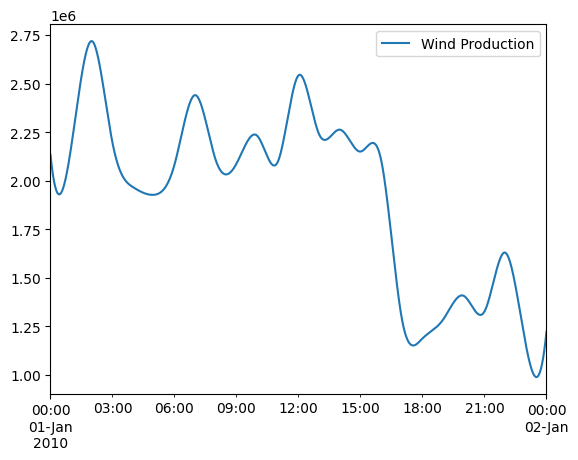

In [74]:
wind_power_norm = wind_power.resample('1T').interpolate(method='polynomial',order=3)
wind_power_norm.plot(legend=True, label='Wind Production')
print(wind_power_norm[:25*60][:-1])

2010-01-01 00:00:00+01:00    2.133588e+06
2010-01-01 00:01:00+01:00    2.133588e+06
2010-01-01 00:02:00+01:00    2.133588e+06
2010-01-01 00:03:00+01:00    2.133588e+06
2010-01-01 00:04:00+01:00    2.133588e+06
                                 ...     
2010-01-01 23:55:00+01:00    1.156412e+06
2010-01-01 23:56:00+01:00    1.156412e+06
2010-01-01 23:57:00+01:00    1.156412e+06
2010-01-01 23:58:00+01:00    1.156412e+06
2010-01-01 23:59:00+01:00    1.156412e+06
Freq: T, Name: feedin_power_plant, Length: 1440, dtype: float64


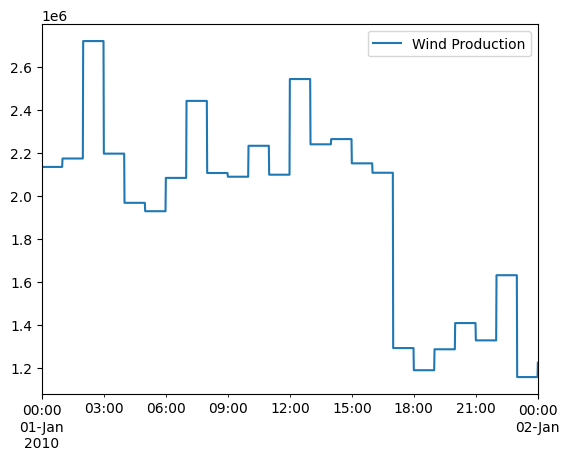

In [75]:
wind_power_norm = wind_power.resample('1T').interpolate(method='pad')
wind_power_norm.plot(legend=True, label='Wind Production')
print(wind_power_norm[:25*60][:-1])